In [63]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
import parse as str_parse
from intersection_proximity import intersection_proximity
from importlib import reload
reload(intersection_proximity)
import seaborn as sns

users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [5]:
crop_rows = 100000

In [6]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip')

if crop_rows > 0:
    df_interactions = df_interactions.head(crop_rows)

isna_result = pd.isna(df_interactions['action'])
df_interactions= df_interactions[~isna_result]
isna_result = pd.isna(df_interactions['action'])
assert sum(df_interactions['action'].isna()) == 0

df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [7]:
# fill nan temporary label id's
df_interactions['temporary_label_id'] = df_interactions['temporary_label_id'].fillna(method='bfill')

# get rid of nan label id's
df_interactions = df_interactions[~pd.isna(df_interactions['temporary_label_id'])]

In [8]:
df_interactions['timestamp'] = df_interactions['timestamp'].apply(lambda x: parse(x))

In [9]:
label_correctness = pd.read_csv('ml-label-correctness.csv')

In [10]:
labeling_cols = ['user_id', 'audit_task_id', 'temporary_label_id']

In [11]:
label_correctness.set_index(labeling_cols, inplace=True)

In [12]:
# TODO: figure out why there are duplicates
label_correctness = label_correctness[~label_correctness.index.duplicated()]

In [13]:
interaction_groups = df_interactions.groupby(labeling_cols)

## Calculate features

In [14]:
label_features = interaction_groups.apply(lambda x: x['zoom'].mean()).to_frame(name='zoom')

In [89]:
# filter rows
label_features = label_features[interaction_groups \
                                .apply(lambda x: sum(x['action'] == 'LabelingCanvas_FinishLabeling') == 1)]

In [85]:
interaction_groups.apply(lambda x: sum(x['action'] == 'LowLevelEvent_mousemove'))

user_id                               audit_task_id  temporary_label_id
0e1ae564-6d72-4670-98e4-71369cc5ab26  3363.0         1.0                    718
                                                     2.0                    634
                                                     3.0                    170
                                                     4.0                    406
                                                     5.0                    151
                                                     6.0                    170
                                                     7.0                    385
                                                     8.0                    139
                                                     9.0                     98
                                                     10.0                    85
                                                     11.0                   564
                                      3364.0    

In [110]:
def label_type(x):
    try:
        note = x['note'][x['action'] == 'LabelingCanvas_FinishLabeling'].iloc[0]
        return str_parse.parse('labelType:{},canvasX:{},canvasY:{}', note)[0]
    except (IndexError, KeyError) as e:
        return ''

label_features['label_type'] = interaction_groups.apply(label_type)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [90]:
label_features['mousemoves'] = interaction_groups.apply(lambda x: sum(x['action'] == 'LowLevelEvent_mousemove'))

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [92]:
def normalize_headings(heading_list):
    start_heading = heading_list.iloc[0]
    h = heading_list - start_heading
    h[h > 180] = h[h > 180] - 360
    return h

def range_headings(heading_list):
    norm = normalize_headings(heading_list)
    return np.max(norm) - np.min(norm)
#     return pd.Series({'heading_min': np.min(norm), 'heading_max': np.max(norm), 'heading_range': np.max(norm) - np.min(norm)})

In [113]:
label_features['heading_range'] = interaction_groups.apply(lambda x: x.groupby('gsv_panorama_id').apply(lambda y: range_headings(y['heading'])).mean())

In [114]:
def total_time(x):
    time = x['timestamp'].sort_values()
    return (time.iloc[-1] - time.iloc[0]).total_seconds()

# Time from start to finish
label_features['total_time'] = interaction_groups.apply(lambda x: total_time(x))

In [115]:
def time_between_pov_change_and_label(x):
    pov_change = x['timestamp'][x['action'] == 'POV_Changed'].max()
    last_time = x['timestamp'].max()
    return (last_time - pov_change).total_seconds()
                                
clicks_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_click') / x['gsv_panorama_id'].unique().size)


In [116]:
label_features['pov_changes_per_pano'] = interaction_groups.apply(lambda x: sum(x['action'] == 'POV_Changed') / x['gsv_panorama_id'].nunique() \
                                                                  if x['gsv_panorama_id'].nunique() > 0 else 0)

In [26]:
def intersection_proximity_percentage(x):
    try:
        evt = x[x['action'] == 'LabelingCanvas_FinishLabeling'].iloc[0]
        try:
            distance, percentage = intersection_proximity.compute_proximity(evt.lat, evt.lng)
            return percentage
        except Exception as e:
#             print(evt.lat, evt.lng)
            # Throws error when the distance is 0 or street length. TODO: fix.
            return 0
    except IndexError as e:
        # TODO: determine why some events have no finishlabeling event
        return -1

In [ ]:
label_features['intersection_proximity'] = interaction_groups.apply(intersection_proximity_percentage)

In [25]:
label_features['intersection_proximity'].shape

(89475,)

In [117]:
label_features['correct'] = label_correctness['correct'].apply(lambda x: True if x == 't' else False if x == 'f' else np.nan)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Make plots

In [118]:
validated_label_features = label_features[~pd.isna(label_features['correct'])]

In [122]:
def plot_intersection_proximity(df, title):
    plt.figure()
    plt.title(title)
    plt.xlabel('intersection proximity (%)')
    plt.ylabel('relative count')
    plt.hist(df[df['correct'] == True]['intersection_proximity'], density=True, alpha=0.2, bins=20, label='correct')
    plt.hist(df[df['correct'] == False]['intersection_proximity'], density=True, alpha=0.2, bins=20, label='incorrect')
    plt.legend()

<IPython.core.display.Javascript object>


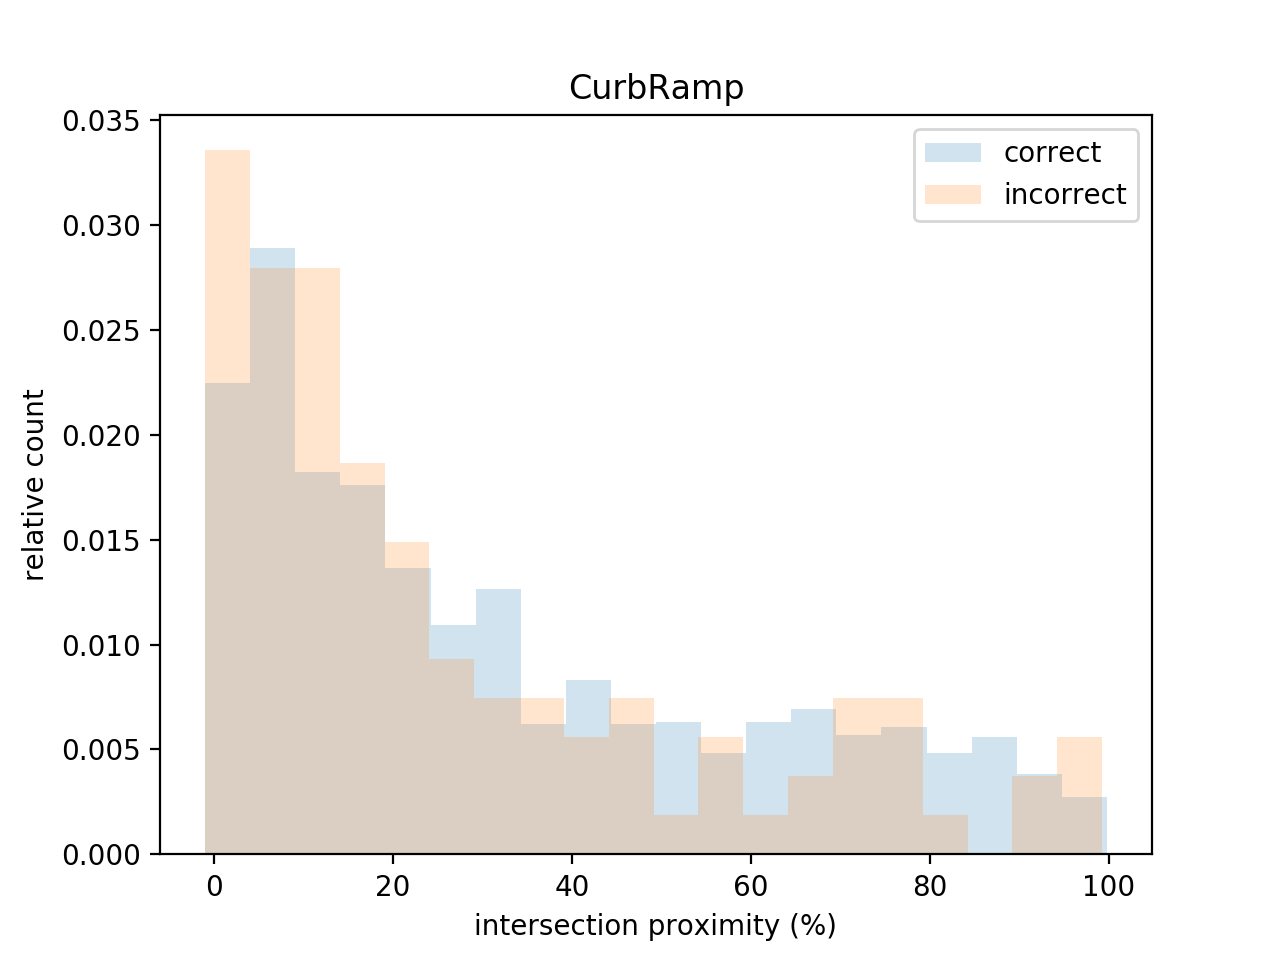

<IPython.core.display.Javascript object>


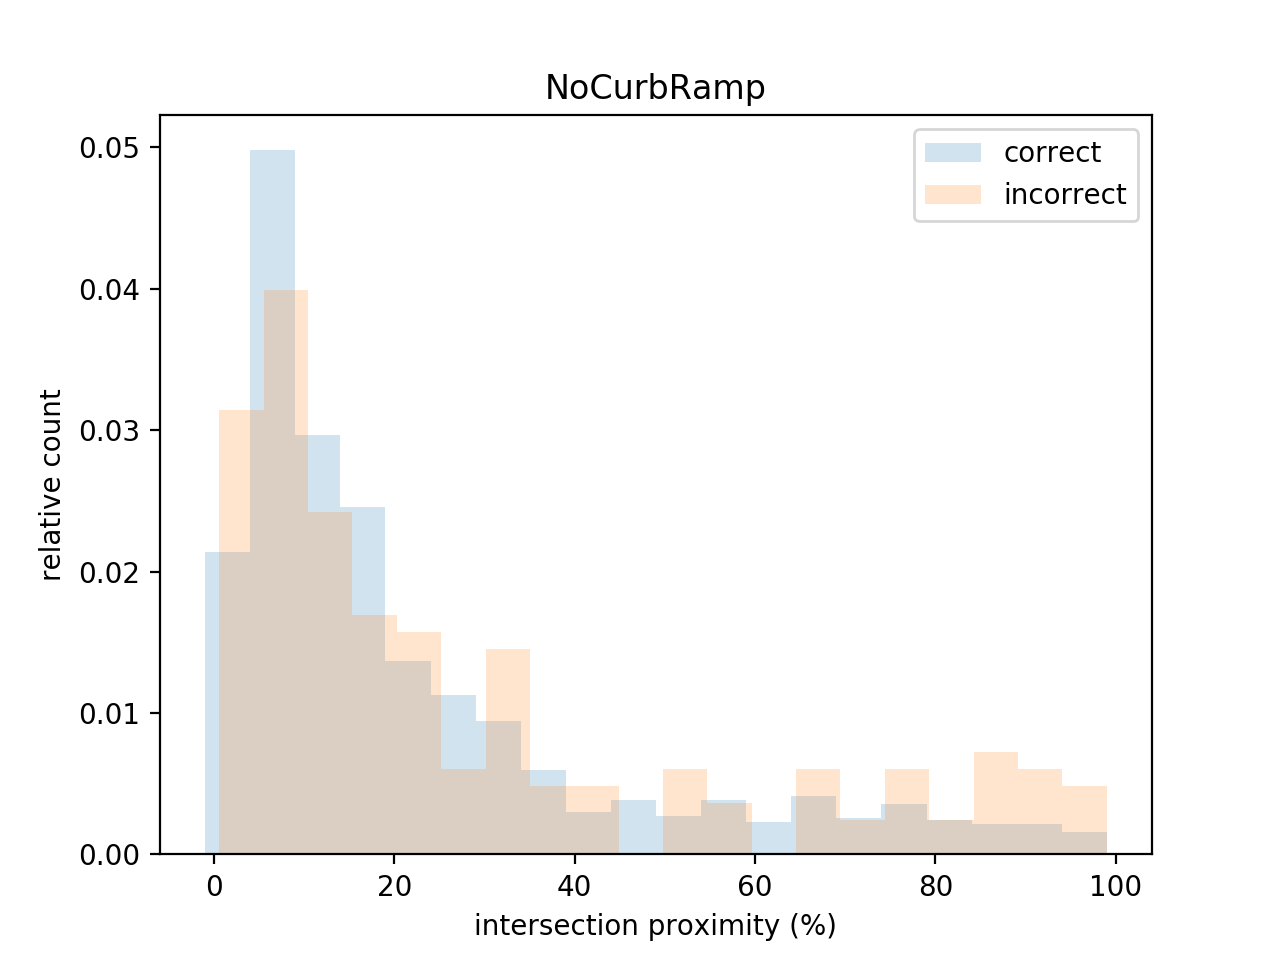

<IPython.core.display.Javascript object>


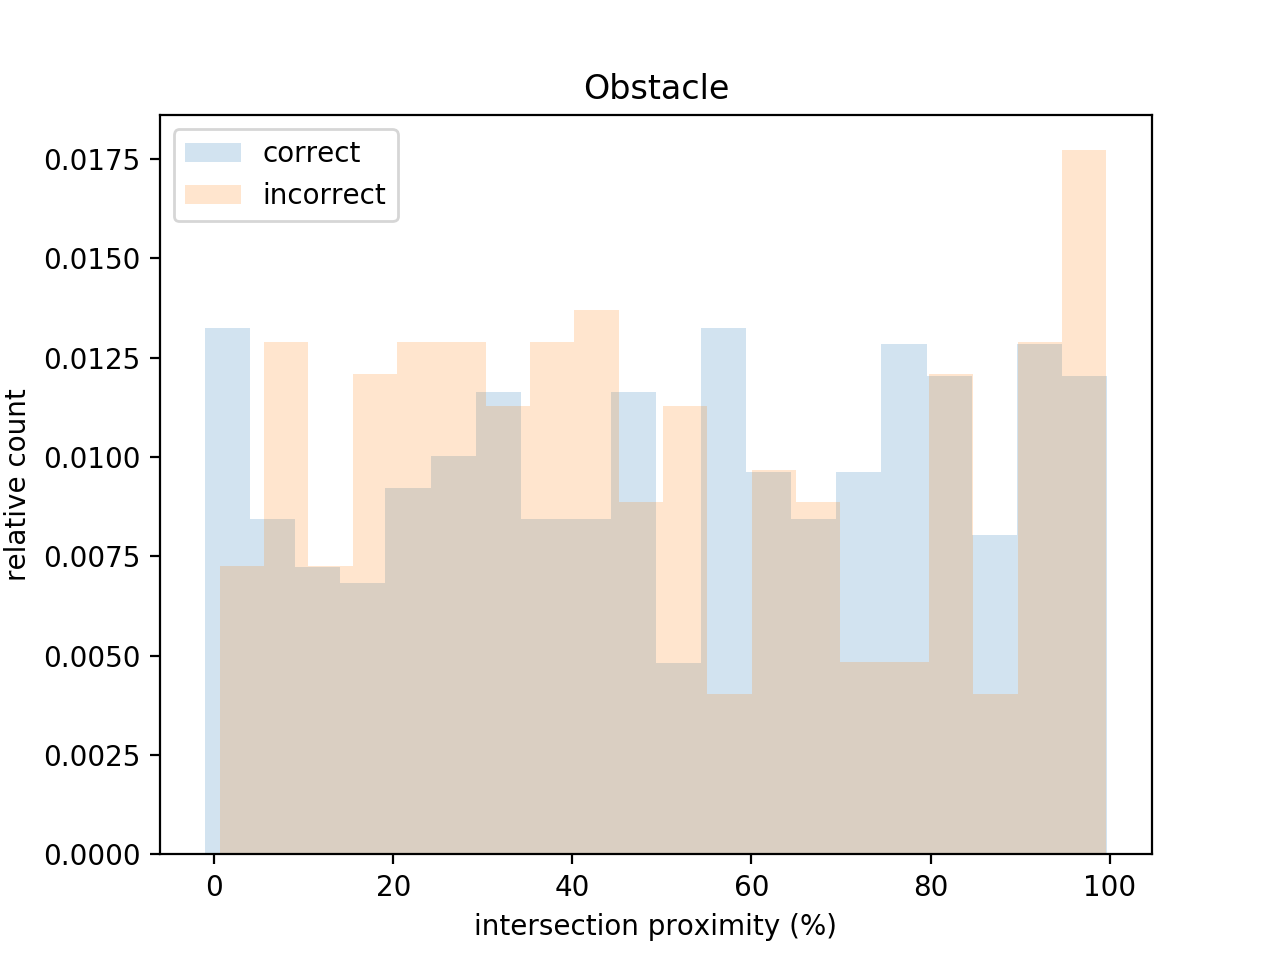

<IPython.core.display.Javascript object>


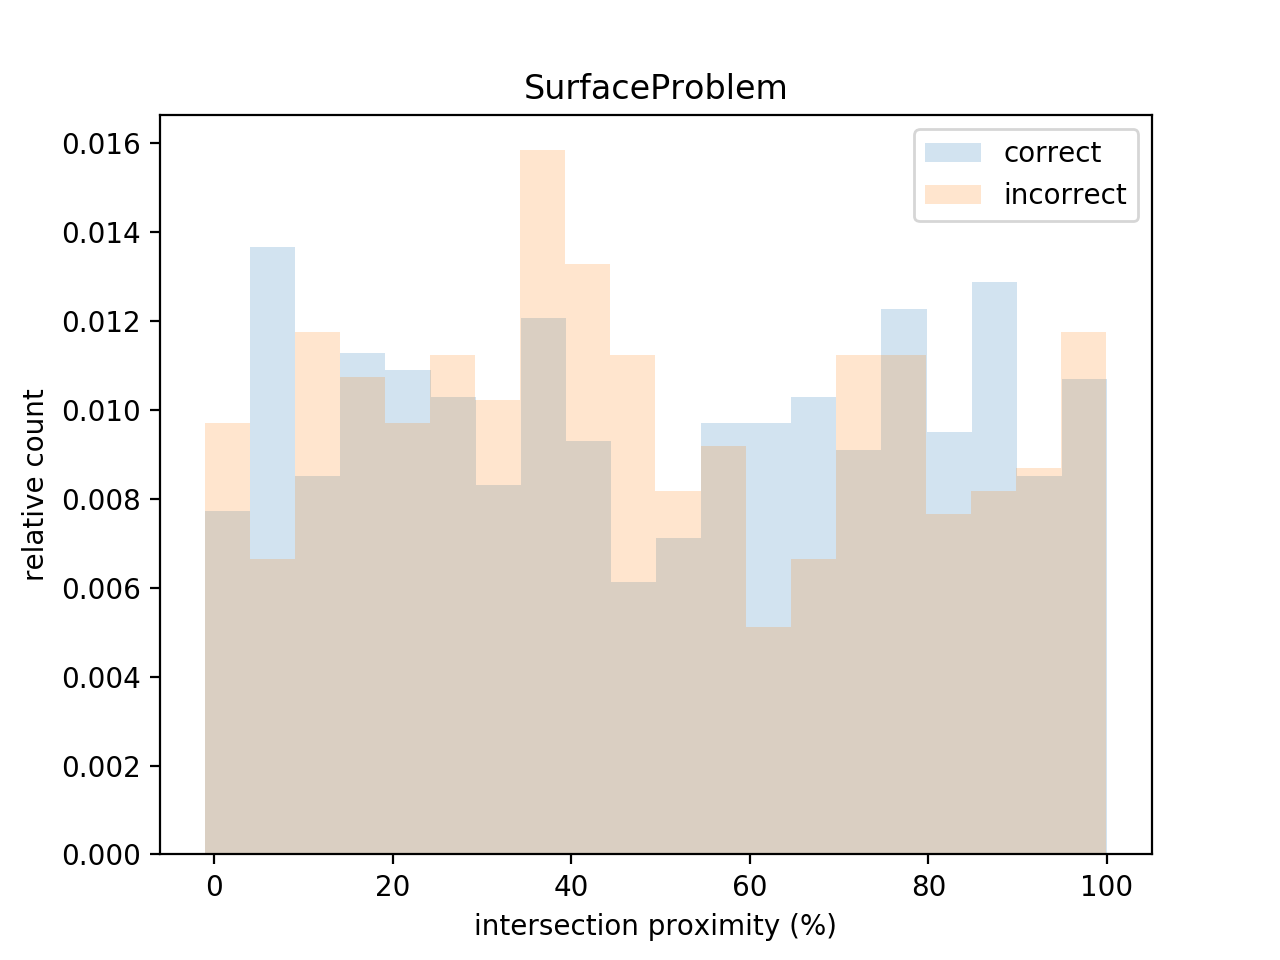

""


In [123]:
validated_label_features.groupby('label_type').apply(lambda x: plot_intersection_proximity(x, x.name))


<IPython.core.display.Javascript object>


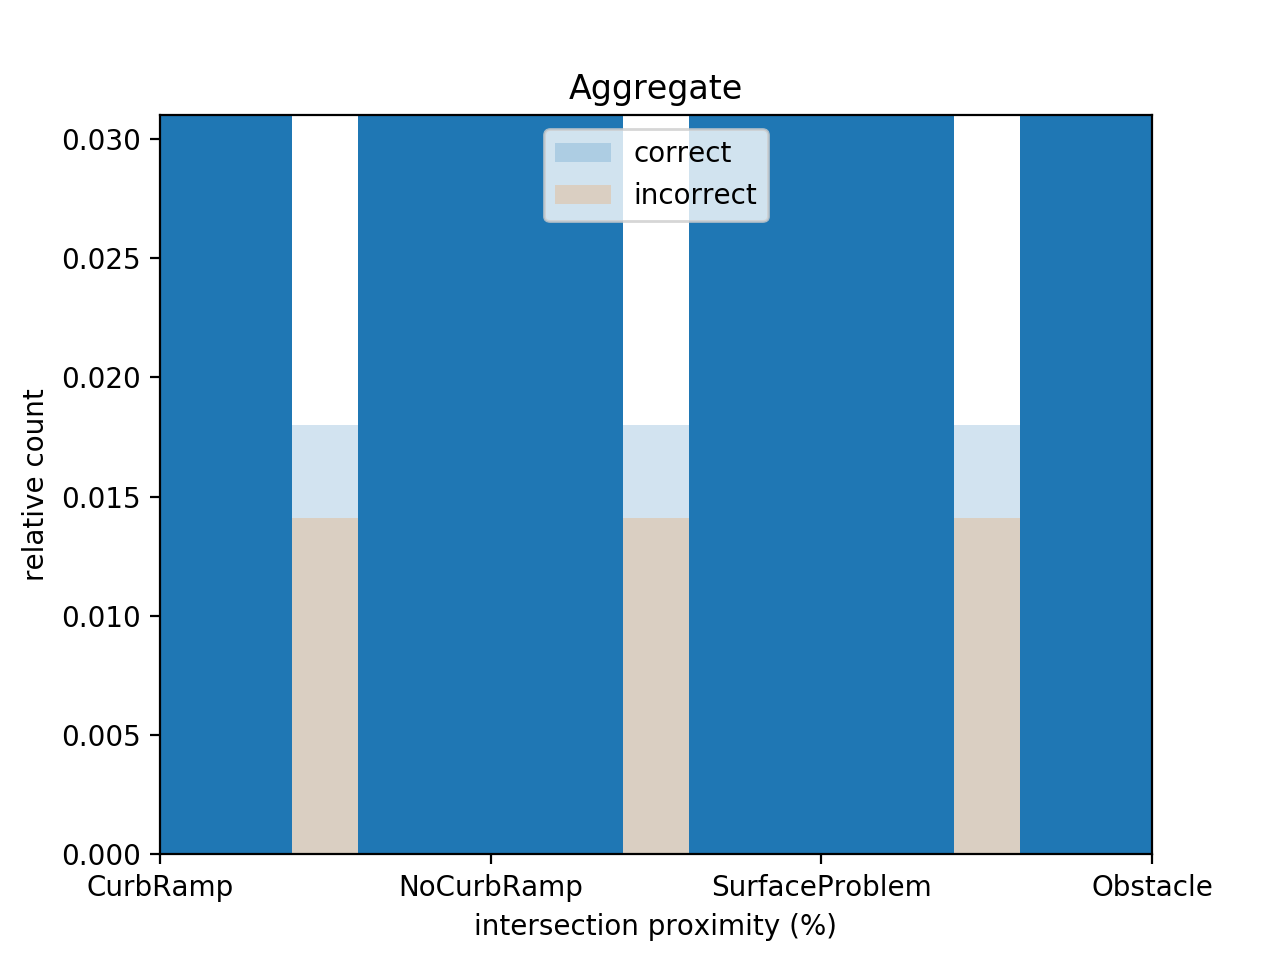

In [124]:
plot_intersection_proximity(validated_label_features, 'Aggregate')

<IPython.core.display.Javascript object>


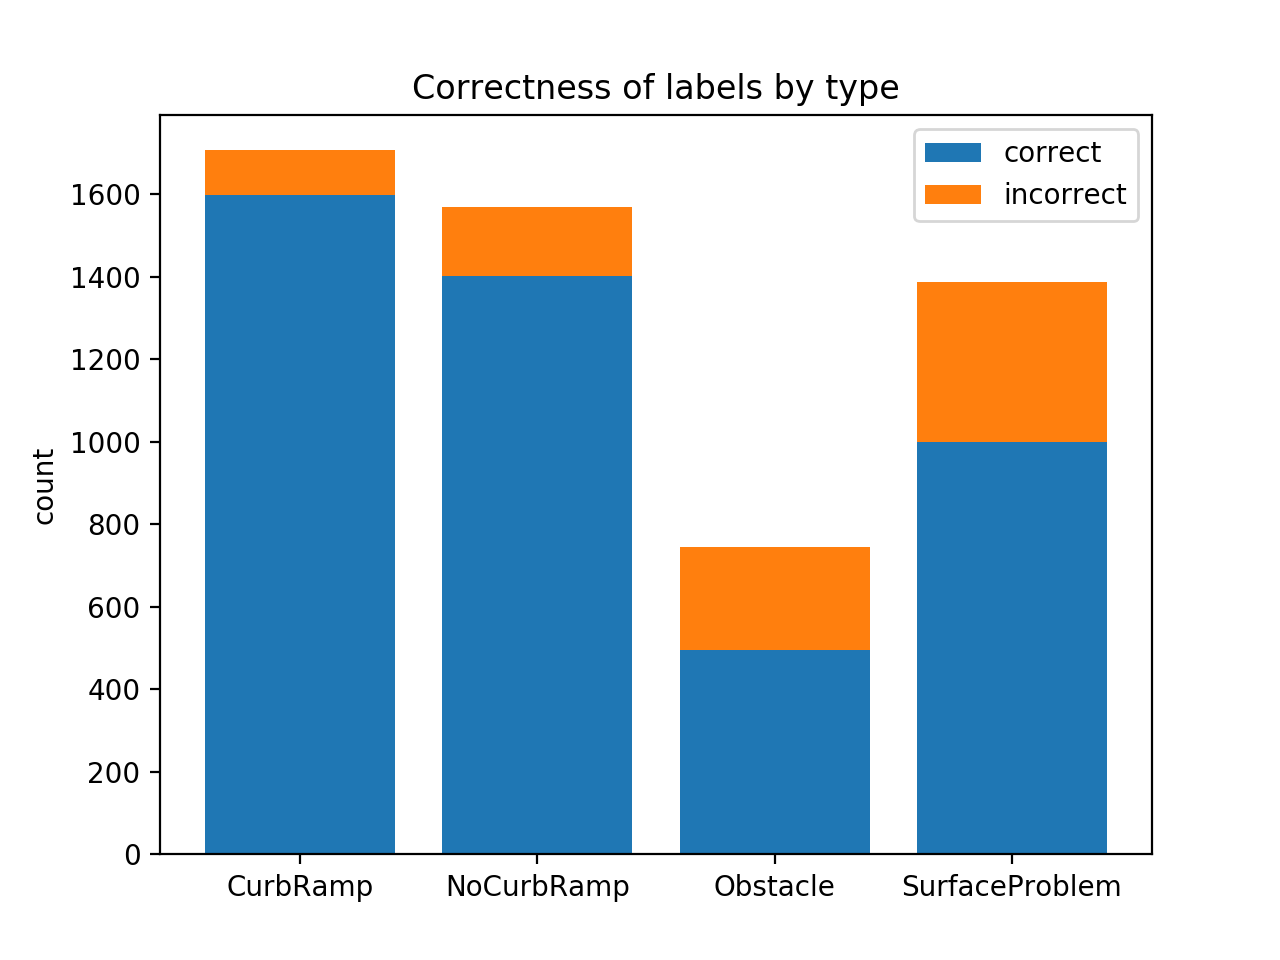

In [169]:
plt.figure()
correct_labels = validated_label_features['label_type'][validated_label_features['correct'] == True].value_counts()
incorrect_labels = validated_label_features['label_type'][validated_label_features['correct'] == False].value_counts()
df = pd.concat([correct_labels.rename('correct'), incorrect_labels.rename('incorrect')], axis=1, sort=True)
plt.bar(df.index, df['correct'], label='correct')
plt.bar(df.index, df['incorrect'], bottom=df['correct'], label='incorrect')
plt.ylabel('count')
plt.title('Correctness of labels by type')
plt.legend()

## Correlation Matrix

<IPython.core.display.Javascript object>


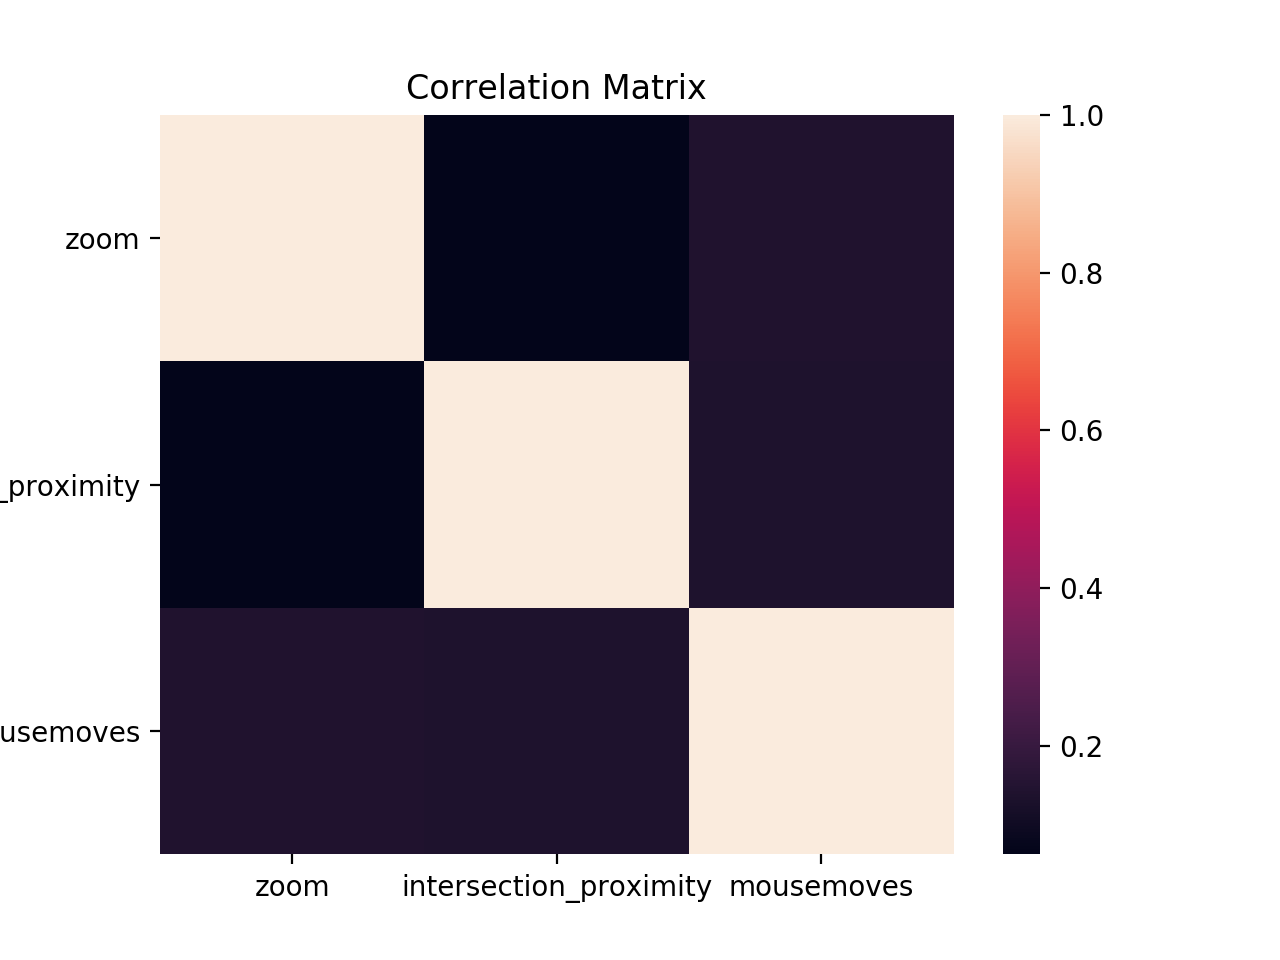

In [171]:
plt.figure()
plt.title('Correlation Matrix')
sns.heatmap(validated_label_features.corr())

<IPython.core.display.Javascript object>


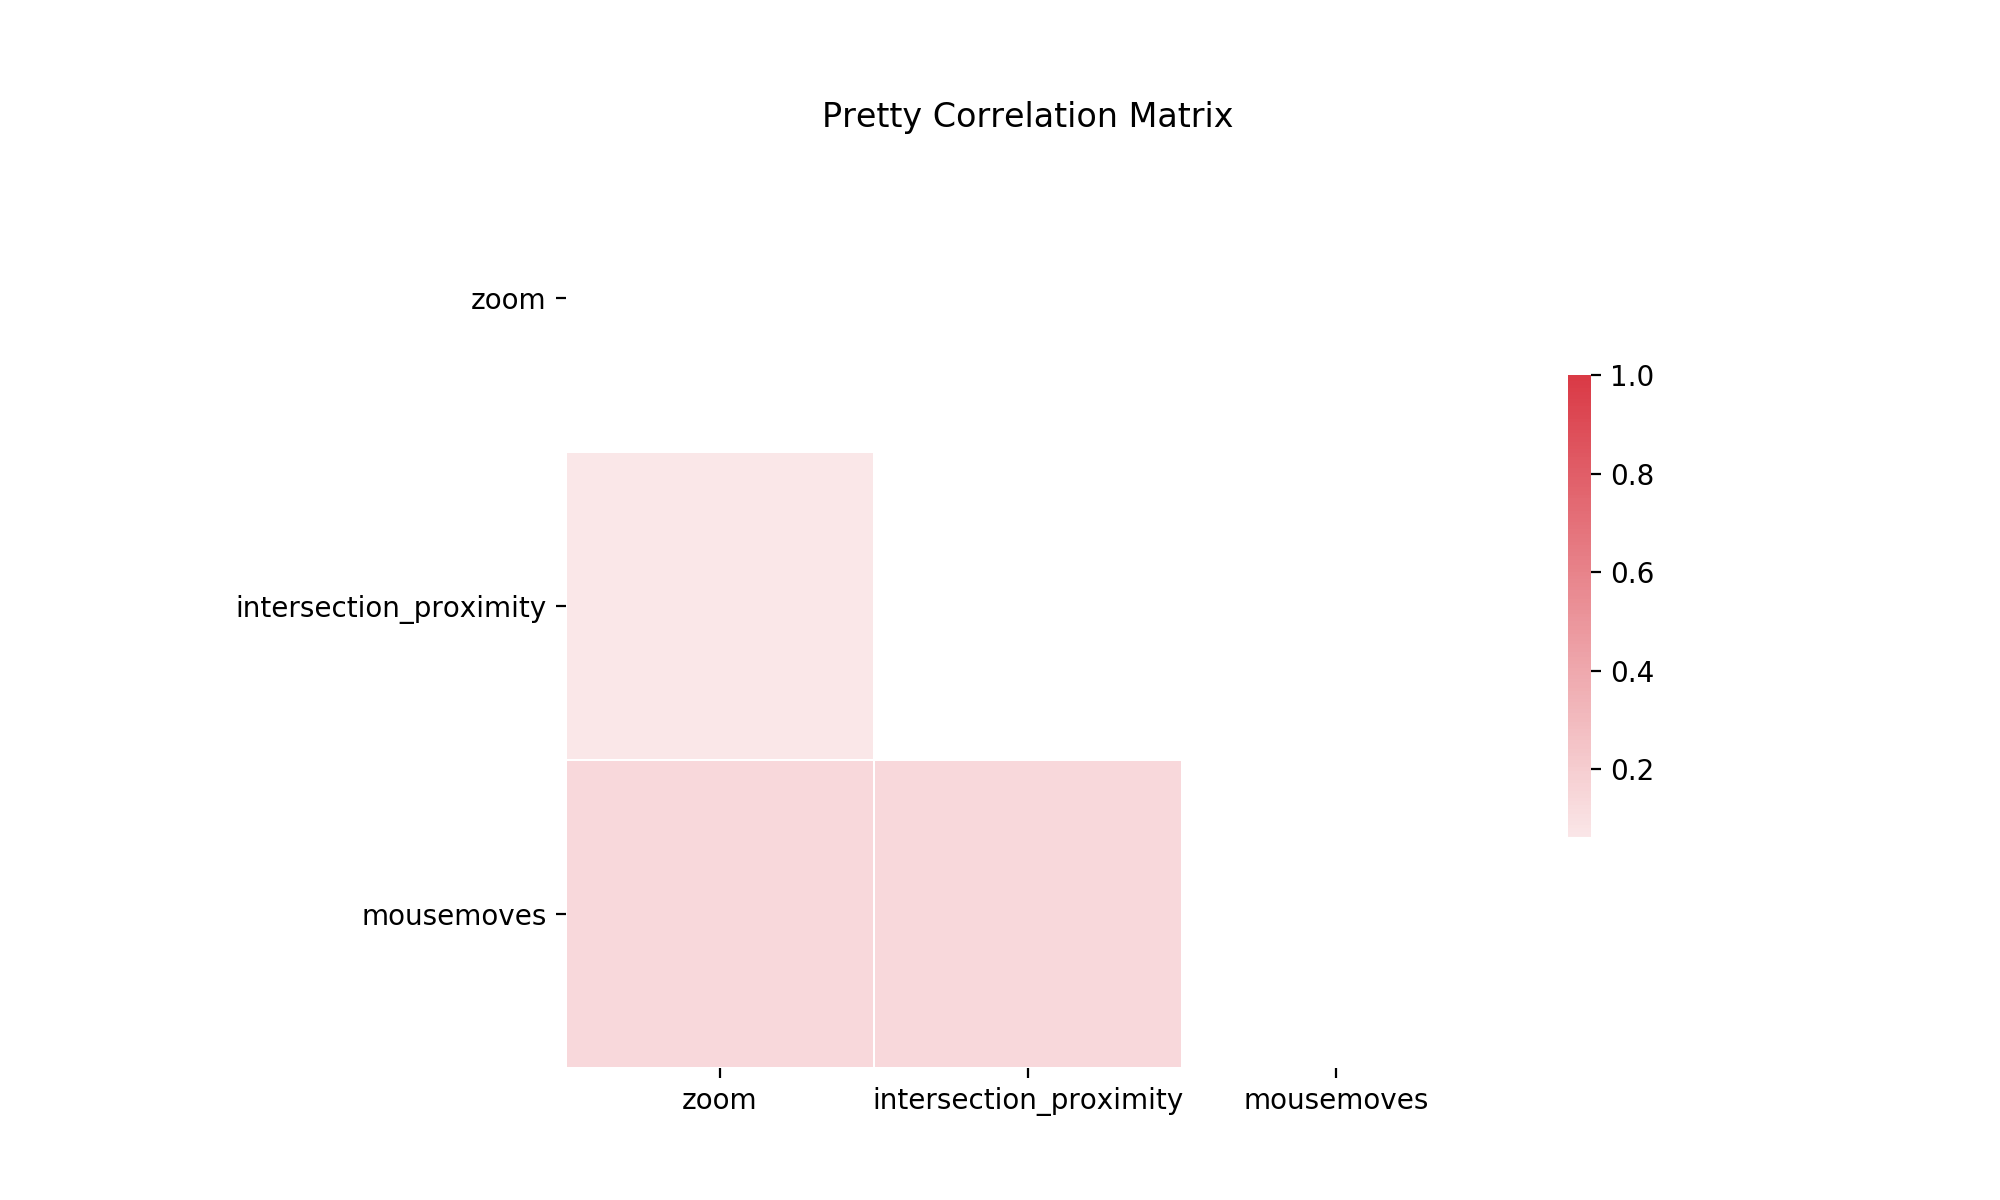

In [172]:
# Compute the correlation matrix
corr = validated_label_features.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from (mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Pretty Correlation Matrix')
# Generate a custom diverging colormap
cmap = sns.diverging_palette (220, 10, as_cmap=True)
# Draw heatmap w/the mask & correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink":.5})